### Time Series Forecasting with Extreme Learning Machines

**Loading the Time Series Dataset**

In [101]:
import pandas as pd
from datetime import datetime
def parser(x):
    return datetime.strptime(x,"%d-%m-%Y")
data = pd.read_csv('./data.csv', header = 0, parse_dates=[0],index_col=0, date_parser=parser)
data

,CLOSE
DATE,
2022-07-12,430.25
2022-07-11,437.00
2022-07-08,441.60
2022-07-07,430.80
2022-07-06,416.30
...,...
2013-01-07,309.83
2013-01-04,311.96
2013-01-03,314.43


**visualize the time series data using matplotlib :**

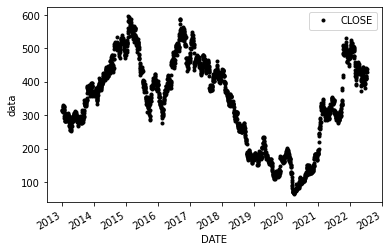

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
data = data.astype(float)
data
data.plot(style='k.',ylabel='data')
plt.show()

**convert the data to a NumPy array to make operations easier :**

In [103]:
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from scipy.linalg import pinv2
data = np.array(data)
data = np.reshape(data, (-1, 1))
data

array([[430.25],
       [437.  ],
       [441.6 ],
       ...,
       [314.43],
       [314.58],
       [313.05]])

**Making Train-Test Splits and Data Normalisation :**

In [104]:
m = 14
per = (1700 - m)/1826
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]
mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

**reshape the train and test data into the form that needs to be fed into the ELM**

In [105]:
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])
for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])
for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2162, 14)
(2162, 1)
(167, 14)
(167, 1)


**Building the ELM model :**

In [106]:
import scipy.stats as stats
input_size = X_train.shape[1]
hidden_size = 100   #no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1 
w_hi = 1
b_lo = -1 
b_hi = 1
#initialising input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)

In [107]:
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H
output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out
prediction = predict(X_test)

/tmp/ipykernel_7789/4033518391.py:6: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)


**Evaluating Time Series Forecasting**

In [108]:
correct = 0
total = X_test.shape[0]
y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)

Test RMSE: 6.733
Test MAPE: 1.771
Test MPE: -0.426


**plot forecasts against actual outcomes :**

Text(0.5, 1.0, 'Forecasting :')

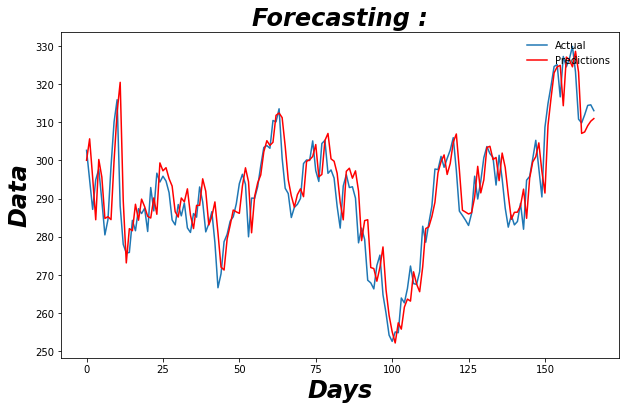

In [110]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('Data',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Forecasting :',fontname="Arial", fontsize=24, style='italic', fontweight='bold')